In [1]:
# Dependencies installation (run these commands in your terminal)
# pip install pandas numpy scikit-learn tensorflow keras matplotlib seaborn xgboost lightgbm boruta
# pip install imbalanced-learn statsmodels scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
import warnings
warnings.filterwarnings('ignore')

# Feature Selection Libraries
from sklearn.feature_selection import (
    VarianceThreshold, chi2, f_classif, mutual_info_classif, 
    SelectKBest, RFE, SelectFromModel
)
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from boruta import BorutaPy
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector

# ML and Evaluation
from keras.models import Sequential
from keras.layers import (
    Dense, Dropout, BatchNormalization
)
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# Load dataset
def load_data(file_path):
    print("Loading dataset...")
    df = pd.read_csv(file_path)
    X = df.drop(columns=['COVID-19'])
    y = df['COVID-19']
    print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Class distribution: {dict(y.value_counts())}")
    return X, y

# Define all feature selection techniques
def get_feature_selectors(X, y, n_features=10):
    print("Initializing feature selection techniques...")
    feature_selectors = {
        "1. Chi-Square": SelectKBest(chi2, k=n_features),
        "2. Mutual Information": SelectKBest(mutual_info_classif, k=n_features),
        "3. Recursive Feature Elimination": RFE(
            estimator=LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
            n_features_to_select=n_features
        ),
        "4. Lasso": SelectFromModel(
            Lasso(alpha=0.01, random_state=42), max_features=n_features
        ),
        "5. Random Forest Importance": SelectFromModel(
            RandomForestClassifier(n_estimators=100, random_state=42), max_features=n_features
        ),
        "6. Boruta": BorutaPy(
            RandomForestClassifier(n_estimators=100, random_state=42),
            n_estimators='auto', verbose=0, random_state=42
        ),
        "7. Correlation-based": None,  # Custom implementation
        "8. Sequential Forward Selection": SequentialFeatureSelector(
            RandomForestClassifier(n_estimators=50, random_state=42),
            n_features_to_select=n_features,
            direction='forward'
        ),
        "9. XGBoost Importance": SelectFromModel(
            XGBClassifier(n_estimators=100, random_state=42), max_features=n_features
        ),
        "10. LightGBM Importance": SelectFromModel(
            LGBMClassifier(n_estimators=100, random_state=42), max_features=n_features
        )
    }
    return feature_selectors

# Function to select top features using each technique
def select_features(X, y, technique_name, selector, n_features=10):
    print(f"Selecting features using {technique_name}...")
    feature_names = X.columns.tolist()
    
    # Handle special case for Correlation-based selection
    if technique_name == "7. Correlation-based":
        # Calculate correlation of each feature with target
        correlations = []
        for col in X.columns:
            corr = np.abs(X[col].corr(y))
            correlations.append((col, corr))
        
        # Sort by correlation and select top n_features
        correlations.sort(key=lambda x: x[1], reverse=True)
        selected_features = [item[0] for item in correlations[:n_features]]
        feature_importances = [item[1] for item in correlations[:n_features]]
        
    # Handle special case for Boruta
    elif technique_name == "6. Boruta":
        # Boruta requires array input
        X_array = X.values
        selector.fit(X_array, y)
        
        # Get the selected features
        selected_mask = selector.support_
        ranking = selector.ranking_
        
        # Sort by ranking and select top features
        feature_ranking = [(feature, rank) for feature, rank, mask in 
                          zip(feature_names, ranking, selected_mask) if mask]
        feature_ranking.sort(key=lambda x: x[1])
        
        # If Boruta selected fewer than n_features, add more by ranking
        if len(feature_ranking) < n_features:
            additional = [(f, r) for f, r, m in 
                         zip(feature_names, ranking, selected_mask) if not m]
            additional.sort(key=lambda x: x[1])
            feature_ranking.extend(additional[:n_features-len(feature_ranking)])
        
        feature_ranking = feature_ranking[:n_features]
        selected_features = [item[0] for item in feature_ranking]
        feature_importances = [1.0/item[1] for item in feature_ranking]  # Invert ranking for visualization
    
    else:
        # Standard scikit-learn selectors
        try:
            selector.fit(X, y)
            
            # Different selector types have different ways to get selected features
            if hasattr(selector, 'get_support'):
                selected_mask = selector.get_support()
                selected_features = [f for f, selected in zip(feature_names, selected_mask) if selected]
                
                # Get feature importances if available
                if hasattr(selector, 'estimator_') and hasattr(selector.estimator_, 'feature_importances_'):
                    feature_importances = selector.estimator_.feature_importances_[selected_mask]
                elif hasattr(selector, 'scores_'):
                    feature_importances = selector.scores_[selected_mask]
                else:
                    feature_importances = np.ones(len(selected_features))
                    
            elif hasattr(selector, 'coef_'):
                # For models with coefficients like Lasso
                coefs = np.abs(selector.coef_)
                indices = np.argsort(coefs)[::-1][:n_features]
                selected_features = [feature_names[i] for i in indices]
                feature_importances = [coefs[i] for i in indices]
                
            else:
                # Get features from the model itself
                try:
                    importances = getattr(selector, 'feature_importances_', 
                                         getattr(selector, 'coef_', None))
                    if importances is None:
                        importances = np.ones(len(feature_names))
                    
                    # For 2D coefficients (like in multiclass), take the mean
                    if importances.ndim > 1:
                        importances = np.mean(np.abs(importances), axis=0)
                    
                    # Select top features
                    indices = np.argsort(np.abs(importances))[::-1][:n_features]
                    selected_features = [feature_names[i] for i in indices]
                    feature_importances = [np.abs(importances)[i] for i in indices]
                    
                except:
                    # Fallback for other selectors
                    indices = getattr(selector, 'support_', np.arange(min(n_features, len(feature_names))))
                    if len(indices) > n_features:
                        indices = indices[:n_features]
                    selected_features = [feature_names[i] for i in indices]
                    feature_importances = np.ones(len(selected_features))
        
        except Exception as e:
            print(f"Error with {technique_name}: {str(e)}")
            # Default to the first n_features if there's an error
            selected_features = feature_names[:n_features]
            feature_importances = np.ones(n_features)
    
    # Ensure exactly n_features are selected (truncate or pad if necessary)
    if len(selected_features) > n_features:
        selected_features = selected_features[:n_features]
        feature_importances = feature_importances[:n_features]
    elif len(selected_features) < n_features:
        # Add remaining features based on variance
        remaining = [f for f in feature_names if f not in selected_features]
        selected_features.extend(remaining[:n_features-len(selected_features)])
        feature_importances = list(feature_importances) + [0] * (n_features - len(feature_importances))
    
    # Print selected features
    print(f"Top {len(selected_features)} features selected by {technique_name}:")
    for i, (feature, importance) in enumerate(zip(selected_features, feature_importances)):
        print(f"{i+1}. {feature}: {importance:.4f}")
    
    return selected_features, feature_importances

# Build the MLP model for a specific set of features
def build_mlp_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train and evaluate model with k-fold cross validation
def train_and_evaluate(X, y, selected_features, technique_name, k=5):
    print(f"\nTraining MLP with features selected by {technique_name}")
    
    # Prepare data for MLP
    X_selected = X[selected_features].values
    y_values = y.values
    
    # K-Fold validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'auc': []
    }
    
    # Define early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=0,
        mode='min',
        restore_best_weights=True
    )
    
    # Train and evaluate for each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_selected)):
        print(f"Training fold {fold+1}/{k}...")
        
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y_values[train_idx], y_values[test_idx]
        
        # Build and train model
        model = build_mlp_model((X_selected.shape[1],))
        model.fit(
            X_train, y_train,
            epochs=50,  # Reduced from 100 for faster execution
            batch_size=32,
            verbose=0,
            validation_split=0.2,
            callbacks=[early_stop]
        )
        
        # Evaluate
        y_pred = model.predict(X_test)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        metrics['accuracy'].append(accuracy_score(y_test, y_pred_classes))
        metrics['precision'].append(precision_score(y_test, y_pred_classes))
        metrics['recall'].append(recall_score(y_test, y_pred_classes))
        metrics['f1'].append(f1_score(y_test, y_pred_classes))
        try:
            metrics['auc'].append(roc_auc_score(y_test, y_pred))
        except:
            metrics['auc'].append(0.5)  # Default for failed AUC calculation
    
    # Calculate average metrics
    avg_metrics = {metric: np.mean(values) for metric, values in metrics.items()}
    std_metrics = {metric: np.std(values) for metric, values in metrics.items()}
    
    print(f"\nResults for {technique_name}:")
    for metric, value in avg_metrics.items():
        print(f"Average {metric}: {value:.4f} ± {std_metrics[metric]:.4f}")
    
    return avg_metrics

# Plot comparison bar chart
def plot_comparison(all_results):
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    
    # Sort techniques by accuracy
    sorted_techniques = sorted(
        all_results.keys(),
        key=lambda x: all_results[x]['accuracy'],
        reverse=True
    )
    
    # Set up the figure
    plt.figure(figsize=(15, 10))
    
    # Set width of bars
    bar_width = 0.15
    index = np.arange(len(sorted_techniques))
    
    # Colors for different metrics
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Plot bars for each metric
    for i, metric in enumerate(metrics_to_plot):
        values = [all_results[technique][metric] for technique in sorted_techniques]
        plt.bar(
            index + i * bar_width, 
            values, 
            bar_width, 
            label=metric.capitalize(),
            color=colors[i]
        )
    
    # Add labels and legend
    plt.xlabel('Feature Selection Technique', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Comparison of Feature Selection Techniques', fontsize=14)
    plt.xticks(
        index + bar_width * 2, 
        [t.split('. ')[1] if '. ' in t else t for t in sorted_techniques],
        rotation=45,
        ha='right'
    )
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    
    # Save figure
    plt.savefig('feature_selection_comparison_MLP.png', dpi=300, bbox_inches='tight')
    print("Comparison chart saved as 'feature_selection_comparison_MLP.png'")
    plt.close()

# Plot feature heatmap
def plot_feature_heatmap(all_features, X):
    # Create a matrix of features vs techniques
    techniques = list(all_features.keys())
    all_unique_features = list(set(feature for features in all_features.values() for feature in features))
    
    # Create a matrix with 1 if feature is selected by technique, 0 otherwise
    matrix = np.zeros((len(techniques), len(all_unique_features)))
    
    for i, technique in enumerate(techniques):
        for j, feature in enumerate(all_unique_features):
            if feature in all_features[technique]:
                matrix[i, j] = 1
    
    # Sort features by frequency of selection
    feature_counts = matrix.sum(axis=0)
    sorted_indices = np.argsort(feature_counts)[::-1]
    sorted_features = [all_unique_features[i] for i in sorted_indices]
    sorted_matrix = matrix[:, sorted_indices]
    
    # Create heatmap
    plt.figure(figsize=(20, 12))
    sns.heatmap(
        sorted_matrix,
        cmap='Blues',
        xticklabels=sorted_features,
        yticklabels=[t.split('. ')[1] if '. ' in t else t for t in techniques],
        cbar_kws={'label': 'Selected'}
    )
    plt.title('Feature Selection by Different Techniques', fontsize=14)
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    # Save figure
    plt.savefig('feature_selection_heatmap_MLP.png', dpi=300, bbox_inches='tight')
    print("Heatmap saved as 'feature_selection_heatmap_MLP.png'")
    plt.close()

# Main function to run the whole process
def main():
    # Load data
    file_path = "preprocessed_covid500_final.csv"  # Update with your path
    X, y = load_data(file_path)
    
    # Get feature selectors
    feature_selectors = get_feature_selectors(X, y)
    
    # Store results
    all_results = {}
    all_selected_features = {}
    
    # For each technique, select features and train model
    for technique_name, selector in feature_selectors.items():
        print("\n" + "="*50)
        print(f"Processing {technique_name}")
        print("="*50)
        
        # Select features
        selected_features, _ = select_features(X, y, technique_name, selector)
        all_selected_features[technique_name] = selected_features
        
        # Train and evaluate
        results = train_and_evaluate(X, y, selected_features, technique_name)
        all_results[technique_name] = results
    
    # Plot comparison
    plot_comparison(all_results)
    
    # Plot feature heatmap
    plot_feature_heatmap(all_selected_features, X)
    
    # Print final summary
    print("\n" + "="*50)
    print("FINAL SUMMARY")
    print("="*50)
    
    # Sort techniques by accuracy
    sorted_techniques = sorted(
        all_results.keys(),
        key=lambda x: all_results[x]['accuracy'],
        reverse=True
    )
    
    print("\nTechniques ranked by accuracy:")
    for i, technique in enumerate(sorted_techniques):
        print(f"{i+1}. {technique}: {all_results[technique]['accuracy']:.4f}")
    
    best_technique = sorted_techniques[0]
    print(f"\nBest performing technique: {best_technique}")
    print(f"Top 10 features selected by {best_technique}:")
    for i, feature in enumerate(all_selected_features[best_technique]):
        print(f"{i+1}. {feature}")

if __name__ == "__main__":
    main()

Loading dataset...
Dataset loaded: 37028 samples, 20 features
Class distribution: {1: np.int64(18514), 0: np.int64(18514)}
Initializing feature selection techniques...

Processing 1. Chi-Square
Selecting features using 1. Chi-Square...
Top 10 features selected by 1. Chi-Square:
1. Breathing Problem: 10855.6785
2. Sore throat: 13892.5526
3. Chronic Lung Disease: 3.2782
4. Heart Disease: 4165.5609
5. Hyper Tension: 3684.8322
6. Attended Large Gathering: 9772.7294
7. Visited Public Exposed Places: nan
8. Family working in Public Exposed Places: 8644.1025
9. Wearing Masks: nan
10. Sanitization from Market: nan

Training MLP with features selected by 1. Chi-Square
Training fold 1/5...
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 2/5...
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 3/5...
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Training fold 4/5...
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training fold 5/5...
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Results for 1. Chi-Sq

# Model Training

Output directory already exists: covid_mlp_results
Results will be saved in: covid_mlp_results
Loading dataset...
Dataset loaded: 37028 samples, 10 features
Class distribution: {1: 18514, 0: 18514}
Selected features: Breathing Problem, Sore throat, Chronic Lung Disease, Heart Disease, Diabetes, Hyper Tension, Attended Large Gathering, Family working in Public Exposed Places, Wearing Masks, Sanitization from Market

Fold 1/10
Epoch 1/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9003 - loss: 0.2601 - val_accuracy: 0.9425 - val_loss: 0.1476
Epoch 2/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9541 - loss: 0.1061 - val_accuracy: 0.9446 - val_loss: 0.1260
Epoch 3/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9597 - loss: 0.0966 - val_accuracy: 0.9478 - val_loss: 0.1286
Epoch 4/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9620 - loss: 0.0899 - val_accuracy: 0.9263 - val_loss: 0.1341
Epoch 5/200
417/417 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step -

Final model saved to covid_mlp_results\final_model_mlp.h5

FINAL SUMMARY

Model Architecture:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                     │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,373 (790.52 KB)

 Trainable params: 67,457 (263.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 134,916 (527.02 KB)


Industry-Standard Parameters Used:
- Dropout rates: 0.3 (first layer), 0.5 (deeper layers)
- Learning rate: 0.001
- Batch size: 64
- Network architecture: 128-256-128-1 neurons
- Early stopping patience: 15 epochs
- Max epochs: 200

Average metrics across all folds:
accuracy: 0.9607 ± 0.0052
precision: 0.9823 ± 0.0117
recall: 0.9386 ± 0.0140
f1: 0.9598 ± 0.0052
mcc: 0.9226 ± 0.0100
auc: 0.9953 ± 0.0010
fpr: 0.0170 ± 0.0117
specificity: 0.9830 ± 0.0117
lr_plus: 69.7105 ± 27.5279
lr_minus: 0.0624 ± 0.0138

All results and model saved to: covid_mlp_results

Full path to output directory: C:\Users\aurok\OneDrive\Desktop\Research_Capstone_Project\covid_mlp_results


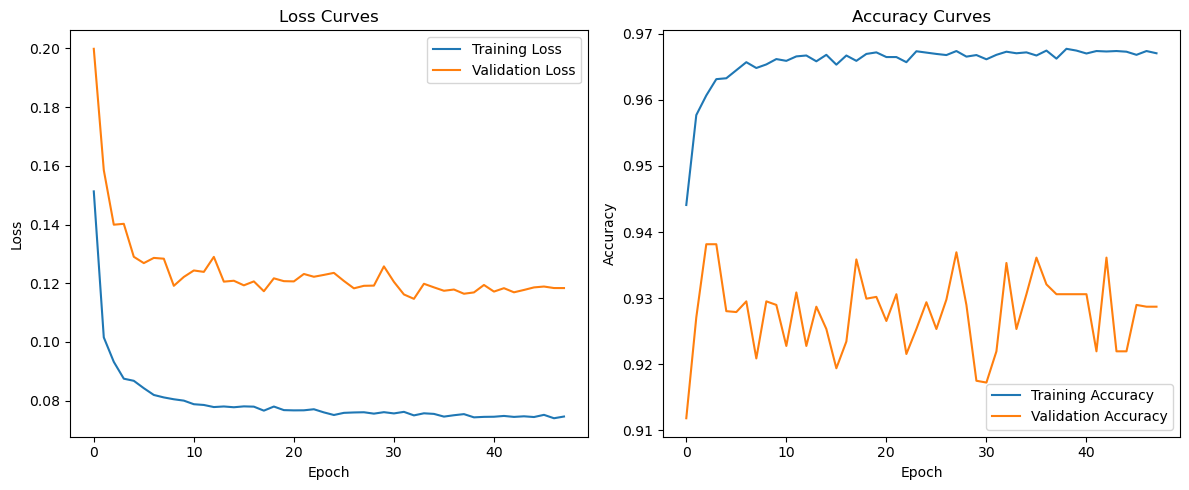

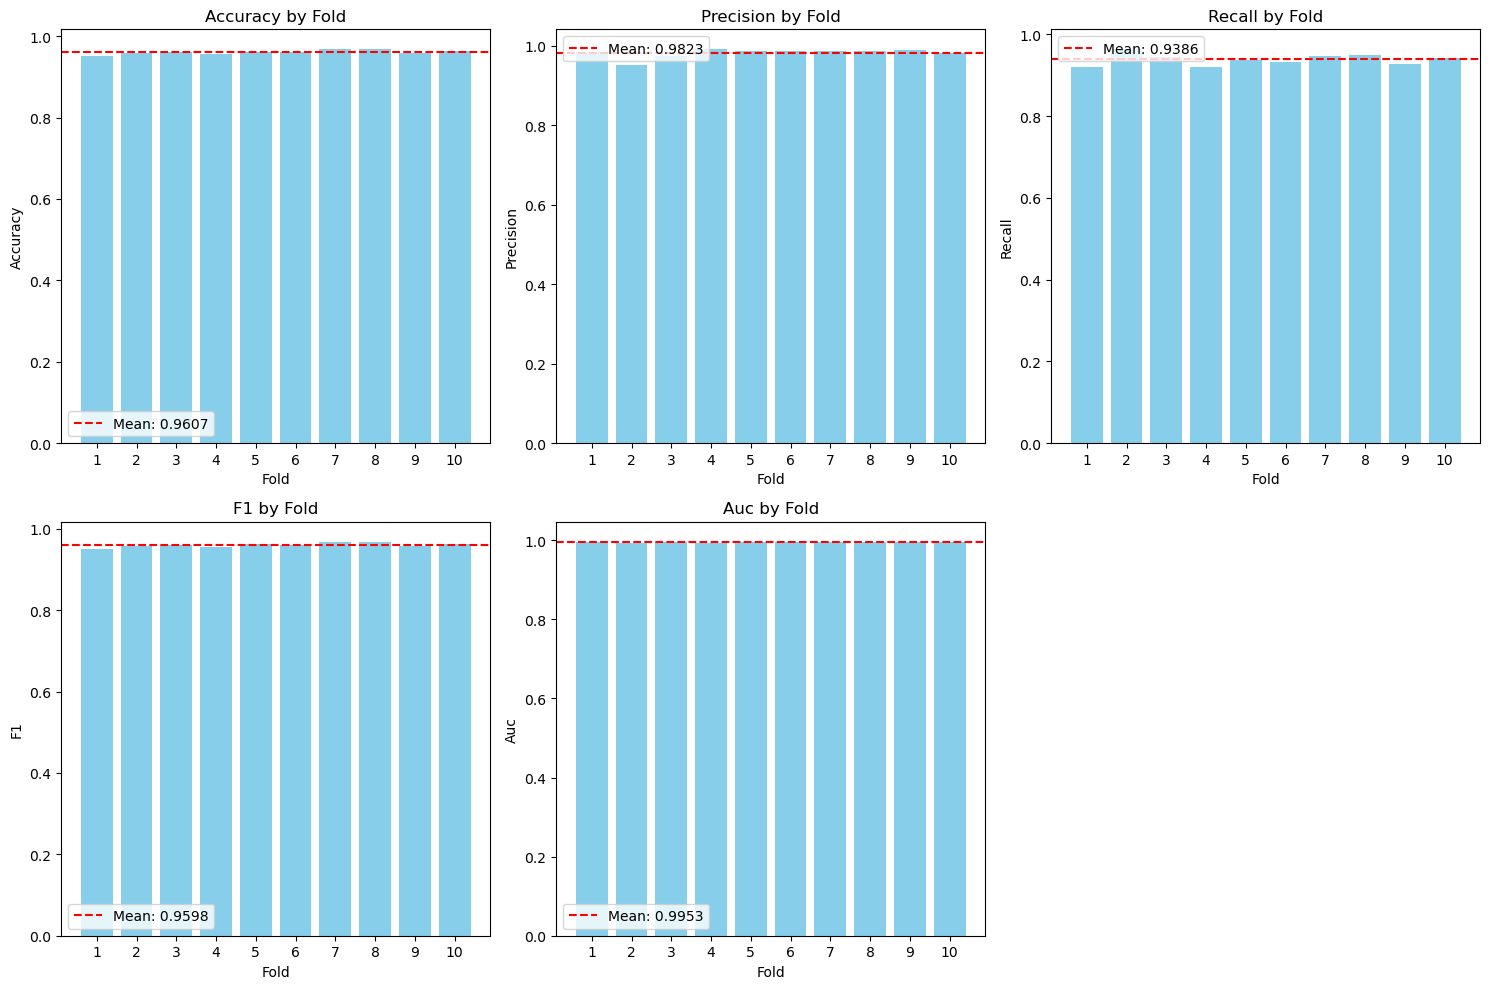

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef
)
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
import tensorflow as tf

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
def load_data(file_path):
    print("Loading dataset...")
    df = pd.read_csv(file_path)
    
    # Use only the specified features
    selected_features = [
        'Breathing Problem', 'Sore throat', 'Chronic Lung Disease',
        'Heart Disease', 'Diabetes', 'Hyper Tension', 'Attended Large Gathering',
        'Family working in Public Exposed Places', 'Wearing Masks', 'Sanitization from Market'
    ]
    
    # Check if all selected features are in the dataframe
    missing_features = [f for f in selected_features if f not in df.columns]
    if missing_features:
        raise ValueError(f"The following features are missing from the dataset: {missing_features}")
    
    X = df[selected_features].values  # No need to reshape for MLP input
    y = df['COVID-19'].values
    
    print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Class distribution: {dict(pd.Series(y).value_counts())}")
    print(f"Selected features: {', '.join(selected_features)}")
    
    return X, y

# Build the MLP model with industry-standard parameters
def create_mlp_model():
    # Industry-standard parameters
    dropout1 = 0.3  # Standard dropout rate for first layer
    dropout2 = 0.5  # Higher dropout for deeper layers
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(10,)),  # First hidden layer
        Dropout(dropout1),
        Dense(256, activation='relu'),  # Second hidden layer
        Dropout(dropout2),
        Dense(128, activation='relu'),  # Additional layer for better feature extraction
        Dropout(dropout2),
        Dense(1, activation='sigmoid')  # Output layer
    ])
    
    # Industry-standard optimizer settings
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Calculate additional metrics
def calculate_metrics(y_true, y_pred, y_pred_proba):
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # AUC-ROC
    try:
        roc_auc = roc_auc_score(y_true, y_pred_proba)
    except:
        roc_auc = 0.5
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # False Positive Rate
    fpr = fp / (fp + tn)
    
    # Likelihood Ratios
    sensitivity = recall
    specificity = tn / (tn + fp)
    lr_plus = sensitivity / (1 - specificity) if (1 - specificity) > 0 else float('inf')
    lr_minus = (1 - sensitivity) / specificity if specificity > 0 else float('inf')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,
        'auc': roc_auc,
        'fpr': fpr,
        'specificity': specificity,
        'lr_plus': lr_plus,
        'lr_minus': lr_minus
    }

# Create output directory
def create_output_directory():
    # Create a local directory for outputs
    output_dir = "covid_mlp_results"
    
    # Create the directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    else:
        print(f"Output directory already exists: {output_dir}")
    
    return output_dir

def main():
    # Create output directory
    output_dir = create_output_directory()
    print(f"Results will be saved in: {output_dir}")
    
    # Load data - using your local path
    file_path = "preprocessed_covid500_final.csv"
    X, y = load_data(file_path)
    
    # 10-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    
    # Store results
    all_metrics = []
    all_fold_histories = []
    
    # For each fold
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold+1}/10")
        print("="*50)
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create model with industry-standard parameters
        model = create_mlp_model()
        
        # Early stopping callback with industry-standard settings
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=15,  # More patience for better convergence
            verbose=1,
            mode='min',
            restore_best_weights=True
        )
        
        # Train the model with industry-standard settings
        history = model.fit(
            X_train, y_train,
            epochs=200,  # Higher max epochs with early stopping
            batch_size=64,  # Larger batch size for better stability
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
        
        all_fold_histories.append(history.history)
        
        # Generate predictions
        y_pred_proba = model.predict(X_test).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate metrics
        fold_metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
        all_metrics.append(fold_metrics)
        
        # Print metrics for this fold
        print(f"\nMetrics for fold {fold+1}:")
        for metric, value in fold_metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # Removed the individual fold model saving
    
    # Train final model on the entire dataset
    print("\nTraining final model on entire dataset...")
    final_model = create_mlp_model()
    
    # Train the final model
    final_early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )
    
    final_history = final_model.fit(
        X, y,
        epochs=200,
        batch_size=64,
        verbose=1,
        validation_split=0.2,
        callbacks=[final_early_stopping]
    )
    
    # Save only the final model
    model_path = os.path.join(output_dir, "final_model_mlp.h5")
    save_model(final_model, model_path)
    print(f"Final model saved to {model_path}")
    
    # Calculate and print average metrics
    metrics_df = pd.DataFrame(all_metrics)
    avg_metrics = metrics_df.mean()
    std_metrics = metrics_df.std()
    
    # Print final summary
    print("\n" + "="*50)
    print("FINAL SUMMARY")
    print("="*50)
    
    print("\nModel Architecture:")
    final_model.summary()
    
    print("\nIndustry-Standard Parameters Used:")
    print("- Dropout rates: 0.3 (first layer), 0.5 (deeper layers)")
    print("- Learning rate: 0.001")
    print("- Batch size: 64")
    print("- Network architecture: 128-256-128-1 neurons")
    print("- Early stopping patience: 15 epochs")
    print("- Max epochs: 200")
    
    print("\nAverage metrics across all folds:")
    for metric in metrics_df.columns:
        print(f"{metric}: {avg_metrics[metric]:.4f} ± {std_metrics[metric]:.4f}")
    
    # Save metrics to CSV
    metrics_df.to_csv(os.path.join(output_dir, "all_fold_metrics.csv"), index=False)
    
    # Save summary metrics
    summary_df = pd.DataFrame({
        'Metric': metrics_df.columns,
        'Mean': avg_metrics.values,
        'Std': std_metrics.values
    })
    summary_df.to_csv(os.path.join(output_dir, "summary_metrics.csv"), index=False)
    
    # Plot training history for final model
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(final_history.history['loss'], label='Training Loss')
    plt.plot(final_history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(final_history.history['accuracy'], label='Training Accuracy')
    plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_history.png"))
    
    # Create a fold comparison plot
    plt.figure(figsize=(15, 10))
    
    # Plot metrics across folds
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(2, 3, i+1)
        plt.bar(range(1, 11), metrics_df[metric], color='skyblue')
        plt.axhline(avg_metrics[metric], color='red', linestyle='--', label=f'Mean: {avg_metrics[metric]:.4f}')
        plt.title(f'{metric.capitalize()} by Fold')
        plt.xlabel('Fold')
        plt.ylabel(metric.capitalize())
        plt.xticks(range(1, 11))
        plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "fold_comparison.png"))
    
    print(f"\nAll results and model saved to: {output_dir}")
    print(f"\nFull path to output directory: {os.path.abspath(output_dir)}")

if __name__ == "__main__":
    main()